This demonstrates two methods of scattering angle computation.

In [1]:
import numpy as np
import cupy as cp
from cupyx import jit
import matplotlib.pyplot as plt

print(f"CuPy version {cp.__version__}")
mempool = cp.get_default_memory_pool()
mempool.free_all_blocks()
print(f"mempool.used_bytes {mempool.used_bytes()}")

CuPy version 11.0.0
mempool.used_bytes 0


In [158]:
@cp.fuse()
def get_theta_fuse(random_in, g):
    temp = (1 - g * g) / (1 - g + random_in)
    cost = (1 + g * g - temp * temp) / (2 * g)
    return cp.arccos(cost)

# deposit the output in the input location
@jit.rawkernel()
def get_theta_raw(random_inout, size, g):
    tid = jit.blockIdx.x * jit.blockDim.x + jit.threadIdx.x
    ntid = jit.gridDim.x * jit.blockDim.x
    for i in range(tid, size, ntid):
        temp = (1 - g * g) / (1 - g + random_inout[i])
        cost = (1 + g * g - temp * temp) / (2 * g)
        random_inout[i] = cp.arccos(cost)

#g = 0.9
g = 0.64
#g = 0.46
#g = 0.1

#size = 300000000
size = 1000000

/home/joel/.local/lib/python3.8/site-packages/cupyx/jit/_interface.py:161: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [3]:
#%%time
#random_input_fuse = cp.random.uniform(0, 2 * g, size, dtype=np.float32)
#theta_fuse = get_theta_fuse(random_input_fuse, g)

In [4]:
#del random_input_fuse, theta_fuse

In [5]:
#%%time
#random_input_fuse = cp.random.uniform(0, 2 * g, size, dtype=np.float32)
#theta_fuse = get_theta_fuse(random_input_fuse, g)

In [6]:
#del random_input_fuse, theta_fuse

In [162]:
random_input = cp.random.uniform(0, 2 * g, size, dtype=np.float32)
print(random_input)
get_theta_raw((128,), (1024,), (random_input, np.int32(size), np.float32(g)))
print(random_input)
tan_ray_angle = 0
correction = np.sqrt(tan_ray_angle ** 2 + 1)
print(correction)
g2 = g ** correction
print(g2)
random_input2 = cp.random.uniform(0, 2 * g2, size, dtype=np.float32)
print(random_input2)
get_theta_raw((128,), (1024,), (random_input2, np.int32(size), np.float32(g2)))
print(random_input2)

[0.11850767 0.5847229  0.42719644 ... 0.07571946 0.7373363  0.99383986]
[1.6589977  0.64992744 0.8475886  ... 1.9104335  0.50516117 0.30888143]
1.0
0.64
[0.9854095  0.5708114  0.12252223 ... 0.06664179 0.74747735 0.03582827]
[0.3149675  0.66496366 1.6392286  ... 1.9766836  0.4965753  2.2611732 ]


[1.6589977  0.64992744 0.8475886  ... 1.9104335  0.50516117 0.30888143]
0.0


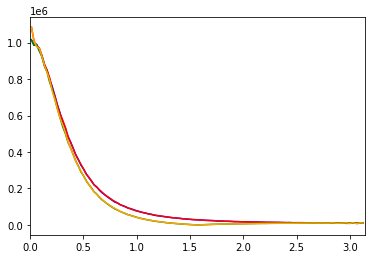

0.63985944
0.6399764


In [163]:
bins = np.int32(128)
print(random_input)
print(cp.nanmin(random_input))
(h,b) = cp.histogram(random_input, bins=bins)
(h2,b2) = cp.histogram(random_input2, bins=bins)

bc = (b[1:]+b[:-1])/2
bc2 = (b2[1:]+b2[:-1])/2

bin_area_sr = (np.cos(b[:-1]) - np.cos(b[1:]) ) * 2 * np.pi
h = h/bin_area_sr
h2 = h2/bin_area_sr
hc = cp.abs(cp.cos(bc))*h
hc2 = cp.abs(cp.cos(bc2))*h2

plt.plot(bc.get(), h.get(), color="blue")
plt.plot(bc2.get(), h2.get(), color="red")
plt.plot(bc.get(), hc.get(), color="green")
plt.plot(bc2.get(), hc2.get(), color="orange")
plt.xlim([0, np.pi])
plt.show()

print(cp.average(cp.cos(random_input))) # should match g
print(cp.average(cp.cos(random_input2)))

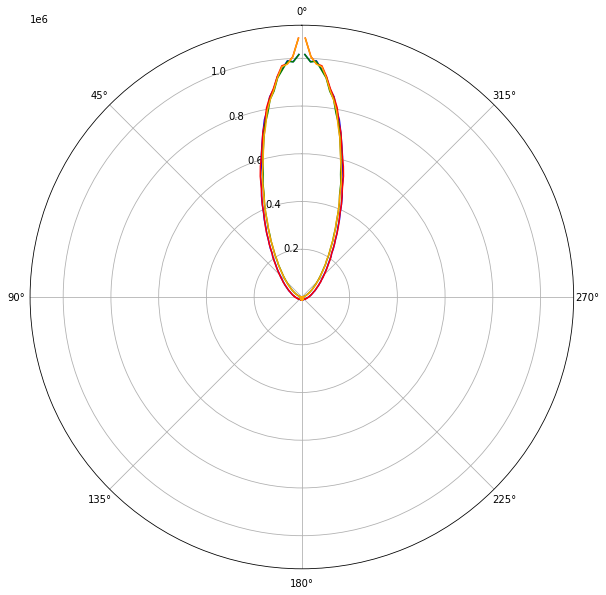

In [164]:
fig = plt.figure(figsize=[10, 10])
axes = plt.subplot(projection="polar")
axes.set_theta_zero_location("N")
axes.plot(bc.get() , h.get(), color="blue", snap=False)
axes.plot(-bc.get() , h.get(), color="blue", snap=False)
axes.plot(bc2.get(), h2.get(), color="red", snap=False)
axes.plot(-bc2.get(), h2.get(), color="red", snap=False)
axes.plot(bc.get() , hc.get(), color="green", snap=False)
axes.plot(-bc.get() , hc.get(), color="green", snap=False)
axes.plot(bc2.get(), hc2.get(), color="orange", snap=False)
axes.plot(-bc2.get(), hc2.get(), color="orange", snap=False)
plt.show()

In [9]:
#print(f"mempool.used_bytes {mempool.used_bytes()}")
#del random_input

In [10]:
#%%time
#random_input = cp.random.uniform(0, 2 * g, size, dtype=np.float32)
#get_theta_raw((128,), (1024,), (random_input, size))

In [11]:
#del random_input_fuse, theta_fuse
#del random_input